* https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/
* https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4

**Given Equation:**

$$
m\frac{d^2u}{dx^2} + \mu\frac{du}{dx} + ku = 0
$$

**Characteristic Equation:**

$$
m\lambda^2 + \mu\lambda + k = 0
$$
$$
\lambda = \frac{-\mu \pm \sqrt{\mu^2 - 4mk}}{2m}
$$

**Discriminant:**

$$
\Delta = \mu^2 - 4mk
$$

**Case 1: Overdamping ($\Delta > 0$)**

$$
\mu^2 > 4mk
$$
$$
\lambda_1, \lambda_2 = \frac{-\mu \pm \sqrt{\mu^2 - 4mk}}{2m}
$$
$$
u(x) = C_1 e^{\lambda_1 x} + C_2 e^{\lambda_2 x}
$$

**Case 2: Critical Damping ($\Delta = 0$)**

$$
\mu^2 = 4mk
$$
$$
\lambda = -\frac{\mu}{2m}
$$
$$
u(x) = (C_1 + C_2 x) e^{\lambda x}
$$

**Case 3: Underdamping ($\Delta < 0$)**

$$
\mu^2 < 4mk
$$
$$
\lambda = -\frac{\mu}{2m} \pm i\frac{\sqrt{4mk - \mu^2}}{2m}
$$
$$
u(x) = e^{-\frac{\mu}{2m} x} \left( C_1 \cos\left(\frac{\sqrt{4mk - \mu^2}}{2m} x\right) + C_2 \sin\left(\frac{\sqrt{4mk - \mu^2}}{2m} x\right) \right)
$$


## Generating dataset

In [1]:
import torch
torch.manual_seed(907)
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
import torch.autograd as autograd
from torch.utils.data import random_split

Simpler equation for underdamped harmonic oscillator
$$
\begin{align}
u &= e^{-\delta x}C_2\sin(\omega x) \\
\delta &= \frac{\mu}{2m} \\
\omega &= \sqrt{\frac{k}{m}-\delta^2}
\end{align}
$$

tensor(2.) tensor(22.2711)


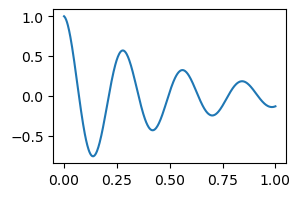

In [2]:
mu=torch.tensor(4)
m=torch.tensor(1.0)
k=torch.tensor(500.0)
delta=mu/(2*m)
omega=torch.sqrt(k/m-(delta**2))
print(delta,omega)
x=torch.linspace(0,1,500)
c2=torch.tensor(1.0)
u = c2*torch.exp(-delta*x)*torch.cos(omega*x)
fig,ax=plt.subplots(1,1)
fig.set_size_inches(3,2)
ax.plot(x,u,label="Real")
data = torch.column_stack([x,u]).numpy()
np.savetxt("./04-data-physicsInformedNN.txt", data,header="x u")

## Preapare Dataset and DataLoader

In [3]:
class DampedHarmonicDataset(Dataset):
    def __init__(self, inputs,targets):
        self.inputs = inputs.unsqueeze(1)
        self.targets = targets.unsqueeze(1)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

data = torch.tensor(np.loadtxt("./04-data-physicsInformedNN.txt", skiprows=1),dtype=torch.float32)
dataset  = DampedHarmonicDataset(inputs=data[0:len(data)*2//5:10,0],targets=data[0:len(data)*2//5:10,1])
val_size = int(0.5*len(dataset)) # fraction
train_size = len(dataset)-val_size


train_size = len(dataset) // 2
val_size = len(dataset) - train_size

# Indices for train and validation datasets
train_indices = list(range(0, len(dataset), 2))
val_indices = list(range(1, len(dataset), 2))

# Subset the dataset
from torch.utils.data import Subset

train_ds = Subset(dataset, train_indices)
val_ds = Subset(dataset, val_indices)
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(10, 10)

In [4]:
batch_size=256
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=0, pin_memory=True)

## Models

In [5]:
class SimpleModel(nn.Module):
    """ Simple Model (No Physics)
        Feedforward neural network with 3 hidden layer
    """
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, output_size)
    
    def forward(self, x):
        # flatten the given image
        x = x.view(x.size(0), -1)
        out = self.linear1(x)
        out = functional.tanh(out)
        out = self.linear2(out)
        out = functional.tanh(out)
        out = self.linear3(out)
        out = functional.tanh(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        x,real = batch
        pred = self.forward(x)
        loss = functional.mse_loss(real,pred)
        return loss
    
    def validation_step(self, batch):
        x,real = batch
        pred = self.forward(x)
        loss = functional.mse_loss(real,pred)
        # acc = self.accuracy(out, labels)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}")   


class PhysicsInformedModel(nn.Module):
    """Physics Informed Model
    Feedforward neural network with 3 hidden layer
    """
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.linear4 = nn.Linear(hidden_size3, output_size)
        
    def forward(self, x):
        # flatten the given image
        x = x.view(x.size(0), -1)
        out = self.linear1(x)
        out = functional.tanh(out)
        out = self.linear2(out)
        out = functional.tanh(out)
        out = self.linear3(out)
        out = functional.tanh(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        x,real = batch
        pred = self.forward(x)
        loss = functional.mse_loss(real,pred)
        x_phys = torch.linspace(0,1,30,requires_grad=True).view(-1,1)
        y_phys = self.forward(x_phys)
        dx1 = autograd.grad(y_phys, x_phys, torch.ones_like(y_phys), create_graph=True)[0]
        dx2 = autograd.grad(dx1, x_phys, torch.ones_like(dx1), create_graph=True)[0]
        residual = m*dx2 + mu * dx1 + k * y_phys
        phys_loss = (1e-4)*torch.mean(residual**2)
        return loss+phys_loss
    
    def validation_step(self, batch):
        x,real = batch
        pred = self.forward(x)
        loss = functional.mse_loss(real,pred)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}")       
        

In [6]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        if epoch%500==0:
            model.epoch_end(epoch, result)
            history.append(result)
    return history

Epoch [0], val_loss: 0.2525
Epoch [500], val_loss: 0.0004


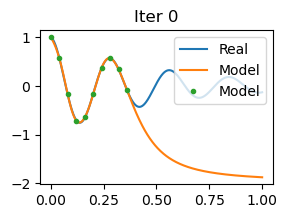

In [7]:
simpleModel=SimpleModel(1,32,32,32,1)
for i in range(0,1):
    fit(1000, 0.001, simpleModel, train_loader, val_loader)
    x=data[:,0]
    real = data[:,1]
    pred = simpleModel(x)
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(3,2)
    ax.plot(x.detach(),real,label="Real")
    ax.plot(x.detach(),pred.detach(),label="Model")
    for x,y in train_loader:
        ax.plot(x,simpleModel(x).detach(),".",label="Model")
    ax.legend(loc="upper right")
    ax.set_title(f"Iter {1000*i}")
    plt.show()

## Physics informed NN

In [8]:
physModel = PhysicsInformedModel(1,32,32,32,1)

Epoch [0], val_loss: 0.2496
Epoch [500], val_loss: 0.2440


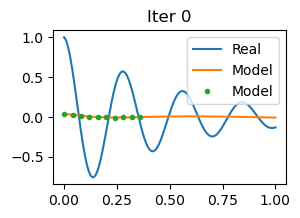

Epoch [0], val_loss: 0.2411
Epoch [500], val_loss: 0.2368


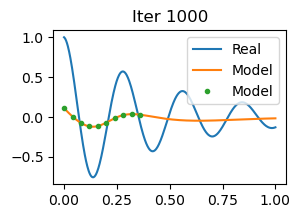

Epoch [0], val_loss: 0.2045
Epoch [500], val_loss: 0.1717


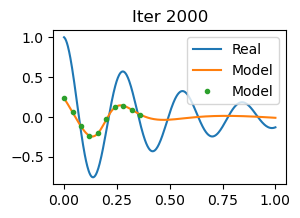

Epoch [0], val_loss: 0.1432
Epoch [500], val_loss: 0.1351


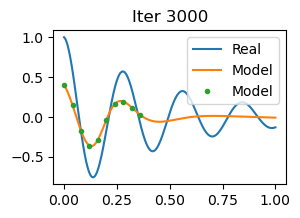

Epoch [0], val_loss: 0.1125
Epoch [500], val_loss: 0.0515


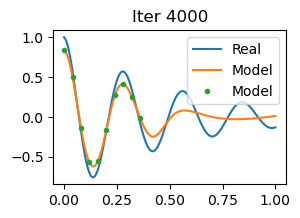

Epoch [0], val_loss: 0.0539
Epoch [500], val_loss: 0.0075


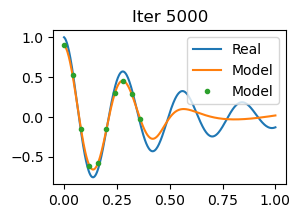

Epoch [0], val_loss: 0.0066
Epoch [500], val_loss: 0.0053


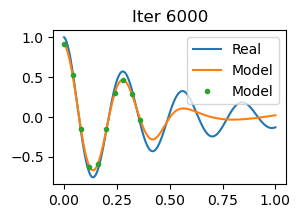

In [9]:
for i in range(0,7):
    fit(1000, 0.001, physModel, train_loader, val_loader)
    x=data[:,0]
    real = data[:,1]
    pred = physModel(x)
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(3,2)
    ax.plot(x,real,label="Real")
    ax.plot(x,pred.detach(),label="Model")
    for x,y in train_loader:
        ax.plot(x,physModel(x).detach(),".",label="Model")
    ax.legend(loc="upper right")
    ax.set_title(f"Iter {1000*i}")
    plt.show()

Epoch [0], val_loss: 0.0344
Epoch [500], val_loss: 0.0047
Epoch [0], val_loss: 0.0316
Epoch [500], val_loss: 0.0040
Epoch [0], val_loss: 0.0382
Epoch [500], val_loss: 0.0035
Epoch [0], val_loss: 0.0284
Epoch [500], val_loss: 0.0029
Epoch [0], val_loss: 0.0036
Epoch [500], val_loss: 0.0018
Epoch [0], val_loss: 0.0540
Epoch [500], val_loss: 0.0009
Epoch [0], val_loss: 0.0044
Epoch [500], val_loss: 0.0006
Epoch [0], val_loss: 0.0124
Epoch [500], val_loss: 0.0005
Epoch [0], val_loss: 0.0147
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0011
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0193
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0408
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0329
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0349
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0332
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0312
Epoch [500], val_loss: 0.0004
Epoch [0], val_loss: 0.0359
Epoch [500], val_loss: 0.0004
Epoch [0], val

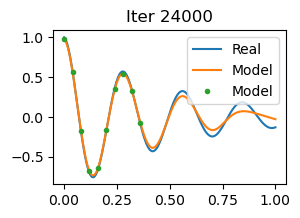

In [10]:
for i in range(7,25):
    fit(1000, 0.001, physModel, train_loader, val_loader)
x=data[:,0]
real = data[:,1]
pred = physModel(x)
fig,ax=plt.subplots(1,1)
fig.set_size_inches(3,2)
ax.plot(x,real,label="Real")
ax.plot(x,pred.detach(),label="Model")
for x,y in train_loader:
    ax.plot(x,physModel(x).detach(),".",label="Model")
ax.legend(loc="upper right")
ax.set_title(f"Iter {1000*i}")
plt.show()